# Utilizando Naive Bayes para Caracterizar Textos que `Podem` ou `Não` ser Fake News

### Importanto Bibliotecas  

In [16]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

# Baixando recursos NLKT (apenas uma vez)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maype\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maype\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Importando Dados de `TREINO`,`TESTE`,`SUBMIT`.
> Estamos atribuindo as bases de `treino` e `teste` um rótulo para facilitar a separação dos dados. 

In [17]:
# Carregando os dados
dados_treino = pd.read_csv("train.csv", sep=",")
dados_teste = pd.read_csv("test.csv", sep=",")
dados_submit = pd.read_csv("submit.csv", sep=",")
# Adicionando rótulos de base
dados_treino['base'] = 'treino'
dados_teste['base'] = 'teste'

> Verificando tamanho da base de `treino`

In [18]:
dados_treino.shape

(20800, 6)

> Verificando tamando da base de `teste`

In [19]:
dados_teste.shape

(5200, 5)

> Concatenando bases de dados para efetuar o mesmo processamento nas bases de `treino` e `teste`
> e covertendo a coluna `text` para o tipo `string` 

In [20]:
# Juntando Bases de treino e teste 
df = pd.concat([dados_treino, dados_teste], ignore_index = True)
df['text'] = df['text'].astype(str)

> Conferindo os dados concatenados

In [21]:
df.head()

,id,title,author,text,label,base
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1.0,treino
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0.0,treino
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1.0,treino
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1.0,treino
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1.0,treino


> Grafico com contagem de valores em `label`

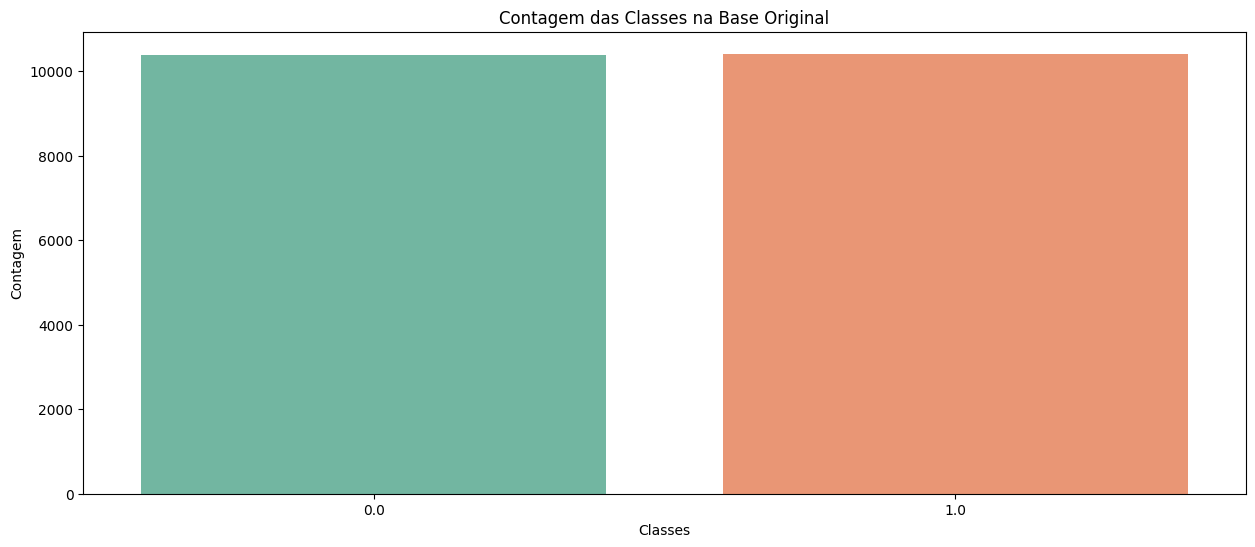

In [22]:
# Contagem das classes na base de dados original
contagem_classes_original = df['label'].value_counts()

# Plotando o gráfico de contagem para a base original
plt.figure(figsize=(15, 6))
sns.countplot(x='label', data=df, palette='Set2')
plt.title('Contagem das Classes na Base Original')
plt.xlabel('Classes')
plt.ylabel('Contagem')
plt.show()


#### Pré Processamento

> Função para separar os textos em `tokens`, remover `stop words`, e reduzir as bases em suas raizes com o `stemmer`

In [23]:
# Pré processamento do Texto 
def preprocess(text):

    #Tokenização
    tokens = word_tokenize(text.lower())

    #Remoção de stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    #Stemming
    tokens = [stemmer.stem(token) for token in tokens]

    #Reune os tokens em uma string
    processed_text = ' '.join(tokens)

    return processed_text

In [24]:
# Iniciando stemmer 
stemmer = PorterStemmer()
# Pré-processando o texto
df['processed_text'] = df['text'].apply(preprocess)

In [ ]:
# Separando os dados de treino e teste
df_treino = df[df['base'] == 'treino'].copy()
df_teste = df[df['base'] == 'teste'].copy()

In [ ]:

# Removendo a coluna "label"
df_teste.drop('label', axis=1, inplace=True)
df_teste.head()

,id,title,author,text,base,processed_text
20800,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",teste,"palo alto , calif. — year scorn polit process ..."
20801,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,teste,russian warship readi strike terrorist near al...
20802,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,teste,video # nodapl : nativ american leader vow sta...
20803,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",teste,"first ’ succeed , tri differ sport . tim tebow..."
20804,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,teste,42 min ago 1 view 0 comment 0 like 'for first ...


In [ ]:
# Adicionando label real de teste 
# Mesclando os DataFrames
df_teste = pd.merge(df_teste, df_submit, on='id', how='left')
df_teste.head()

,id,title,author,text,base,processed_text,label
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",teste,"palo alto , calif. — year scorn polit process ...",0
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,teste,russian warship readi strike terrorist near al...,1
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,teste,video # nodapl : nativ american leader vow sta...,0
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",teste,"first ’ succeed , tri differ sport . tim tebow...",1
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,teste,42 min ago 1 view 0 comment 0 like 'for first ...,1


In [ ]:
# Verificando df_treino
df_treino.head()


,id,title,author,text,label,base,processed_text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1.0,treino,hous dem aid : ’ even see comey ’ letter jason...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0.0,treino,ever get feel life circl roundabout rather hea...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1.0,treino,"truth might get fire octob 29 , 2016 tension i..."
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1.0,treino,video 15 civilian kill singl us airstrik ident...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1.0,treino,print iranian woman sentenc six year prison ir...


In [ ]:
# Removendo a coluna 'base'
df_treino.drop('base', axis=1, inplace=True)
df_teste.drop('base', axis=1, inplace=True)

In [ ]:
# Vetorização TF-IDF
vectorizer = TfidfVectorizer()

In [ ]:
# Separando treino e teste
x_train = vectorizer.fit_transform(df_treino['processed_text'])  # fit_transform para o treino
y_train = df_treino['label']
x_test = vectorizer.transform(df_teste['processed_text'])  # transform para o teste
y_test = df_teste['label']

In [ ]:
# Verificando quandidade de palavras nos conjuntos
x_train.shape()

In [ ]:
x_test.shape()

In [ ]:
# Definindo o modelo Naive Bayes
model = MultinomialNB()

In [ ]:
# Parâmetros para o GridSearchCV
param_grid = {
    'alpha': [0.1, 1, 10],
    'fit_prior': [True, False]
}

# Treinando o modelo com GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(x_train, df_treino['label'])


GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 1, 10], 'fit_prior': [True, False]},
             scoring='accuracy')

In [ ]:
# Obtendo os melhores parâmetros
best_params = grid_search.best_params_
print(f"Melhores parâmetros: {best_params}")

Melhores parâmetros: {'alpha': 0.1, 'fit_prior': True}


In [ ]:
# Treinando o modelo final com os melhores parâmetros
model = MultinomialNB(**best_params)
model.fit(x_train, df_treino['label'])

MultinomialNB(alpha=0.1)

In [ ]:
# Fazendo a predição no conjunto de teste
y_pred = model.predict(x_test)

In [ ]:
# Avaliando o modelo
accuracy = accuracy_score(df_submit['label'], y_pred)
print(f"Acurácia do modelo: {accuracy:.4f}")

Acurácia do modelo: 0.6021


In [ ]:
# Relatório de Classificação
print(classification_report(df_submit['label'], y_pred))

              precision    recall  f1-score   support

           0       0.55      0.67      0.60      2339
           1       0.67      0.54      0.60      2861

    accuracy                           0.60      5200
   macro avg       0.61      0.61      0.60      5200
weighted avg       0.62      0.60      0.60      5200



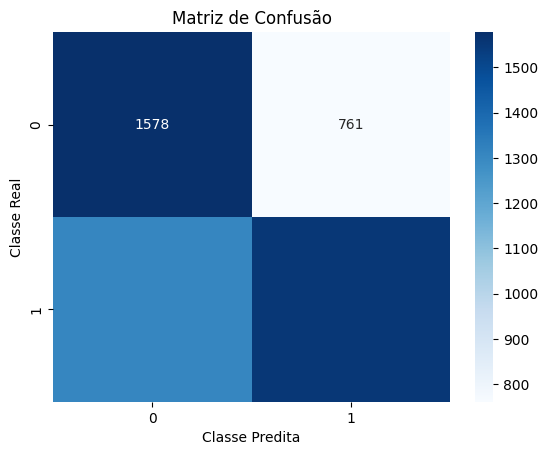

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df_submit['label'], y_pred)
classes = [0,1]
sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes, fmt='d', cmap='Blues')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
cm

array([[1578,  761],
       [1308, 1553]], dtype=int64)

In [ ]:
print(f"Tamanho de df_submit['label']: {len(df_submit['label'])}")
print(f"Tamanho de y_pred: {len(y_pred)}")
print(f"Tamanho de x_test: {x_test.shape[0]}")
print(f"Tamanho de df_teste: {len(df_teste)}")

Tamanho de df_submit['label']: 5200
Tamanho de y_pred: 5200
Tamanho de x_test: 5200
Tamanho de df_teste: 5200


In [ ]:
# Obtenção das probabilidades logarítmicas das características
feature_names = vectorizer.get_feature_names_out()
log_probs = model.feature_log_prob_  # Obter as probabilidades logarítmicas

# Criando um DataFrame para facilitar a análise
coef_df = pd.DataFrame({'Palavra': feature_names})

# Adicionando as probabilidades logarítmicas para cada classe
for i, class_name in enumerate(model.classes_):
    coef_df[f'Log Probabilidade {class_name}'] = log_probs[i]

# Ordenando as palavras pelo valor absoluto do coeficiente
# (Neste caso, usaremos a probabilidade logarítmica da classe 1, que é "fake")
coef_df = coef_df.sort_values(by='Log Probabilidade 1.0', ascending=False)

In [ ]:
# Selecionando as 20 palavras com maiores coeficientes positivos e negativos
top_positive = coef_df.head(20)
top_negative = coef_df.tail(20)

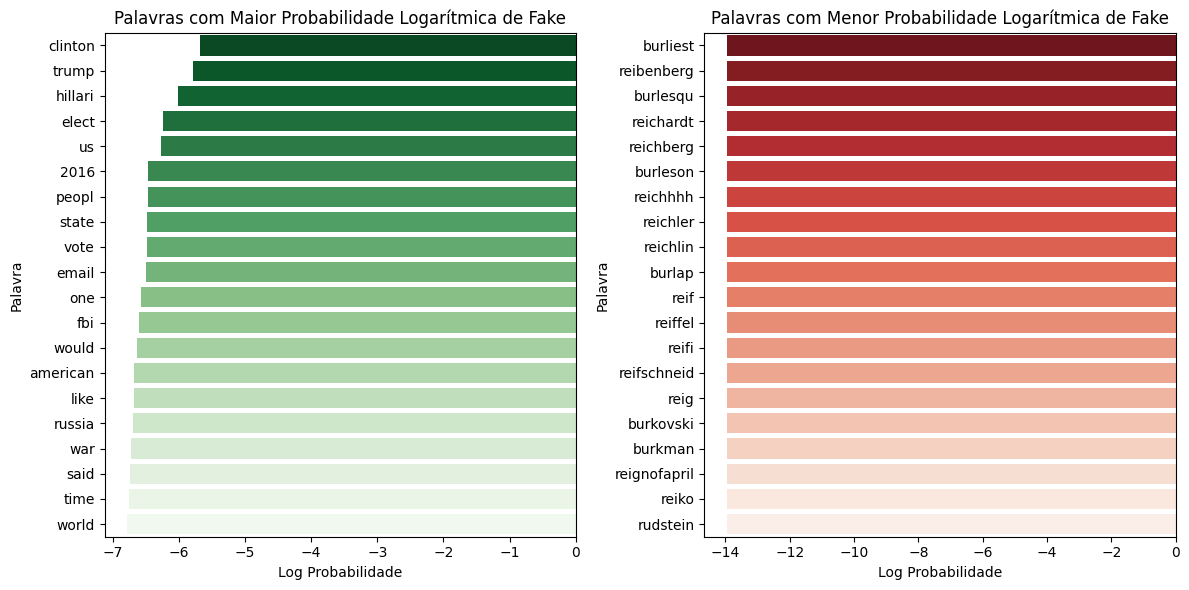

In [ ]:
# Plotando o gráfico de barras para as palavras mais importantes
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Log Probabilidade 1.0', y='Palavra', data=top_positive, orient='h', palette='Greens_r')
plt.title('Palavras com Maior Probabilidade Logarítmica de Fake')
plt.xlabel('Log Probabilidade')
plt.ylabel('Palavra')

plt.subplot(1, 2, 2)
sns.barplot(x='Log Probabilidade 1.0', y='Palavra', data=top_negative, orient='h', palette='Reds_r')
plt.title('Palavras com Menor Probabilidade Logarítmica de Fake')
plt.xlabel('Log Probabilidade')
plt.ylabel('Palavra')

plt.tight_layout()
plt.show()